In [11]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
from numpy.random import seed
seed(0)
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU

from itertools import cycle

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import yfinance as yf


In [12]:
# Data from SP500
SPX = yf.Ticker("^GSPC")
SPX.info

YFRateLimitError: Too Many Requests. Rate limited. Try after a while.

In [5]:
SPX_values = SPX.history(start="2015-01-01",end="2025-04-20")
SPX_values

YFRateLimitError: Too Many Requests. Rate limited. Try after a while.

In [ ]:
SPX_values.index = pd.to_datetime(SPX_values.index)
SPX_values.reset_index(inplace=True)

In [95]:
closedf = SPX_values[['Date','Close']]
closedf

,Date,Close
0,2015-01-02 00:00:00-05:00,2058.199951
1,2015-01-05 00:00:00-05:00,2020.579956
2,2015-01-06 00:00:00-05:00,2002.609985
3,2015-01-07 00:00:00-05:00,2025.900024
4,2015-01-08 00:00:00-05:00,2062.139893
...,...,...
2584,2025-04-11 00:00:00-04:00,5363.359863
2585,2025-04-14 00:00:00-04:00,5405.970215
2586,2025-04-15 00:00:00-04:00,5396.629883
2587,2025-04-16 00:00:00-04:00,5275.700195


In [98]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(np.array(closedf['Close']).reshape(-1, 1))
closedf['Close'] = scaled_close
del closedf['Scaled_Close']
print(closedf.head()) 

                       Date     Close
0 2015-01-02 00:00:00-05:00  0.053098
1 2015-01-05 00:00:00-05:00  0.044379
2 2015-01-06 00:00:00-05:00  0.040215
3 2015-01-07 00:00:00-05:00  0.045612
4 2015-01-08 00:00:00-05:00  0.054011


C:\Users\Admin\AppData\Local\Temp\ipykernel_12376\4210271479.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  closedf['Close'] = scaled_close


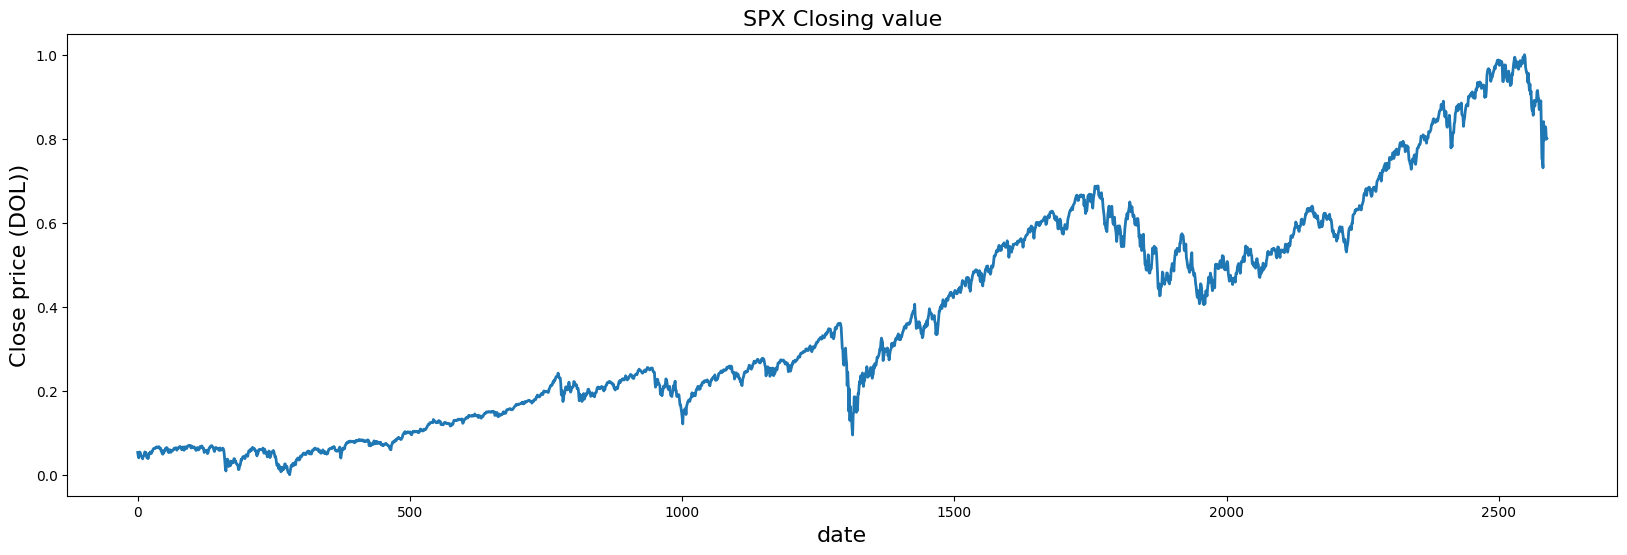

In [99]:
plt.figure(figsize=(20,6))
plt.plot(closedf.index, closedf['Close'], lw=2)
plt.xlabel("date")
plt.xlabel("date", fontsize=16)
plt.ylabel("Close price (DOL))", fontsize=16)
plt.title("SPX Closing value", fontsize=16);

# Create train and test data

In [ ]:
split_index = int(len(closedf) * 0.65)

train_data = closedf.iloc[:split_index]
test_data = closedf.iloc[split_index:]

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (1682, 2)
test_data:  (907, 2)


In [ ]:
def create_dataset(data, time_step=15):
    X, y = [], []
    prices = data['Close'].values 

    for i in range(len(prices) - time_step):
        X.append(prices[i:i+time_step])      
        y.append(prices[i + time_step])       

    return np.array(X), np.array(y)

In [ ]:
time_step = 15

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train:", X_train.shape) 
print("y_train:", y_train.shape)  
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)


X_train: (1667, 15)
y_train: (1667,)
X_test: (892, 15)
y_test: (892,)


# LSTM neural network

In [ ]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (1667, 15, 1)
X_test:  (892, 15, 1)


In [104]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(LSTM(32,return_sequences=True,input_shape=(time_step,1)))
model.add(LSTM(32,return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [105]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 15, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 21025 (82.13 KB)
Trainable params: 21025 (82.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [106]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=5,verbose=1)

Epoch 1/200
334/334 [==============================] - 19s 29ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 2/200
334/334 [==============================] - 8s 23ms/step - loss: 3.8067e-04 - val_loss: 9.5536e-04
Epoch 3/200
334/334 [==============================] - 8s 23ms/step - loss: 3.4839e-04 - val_loss: 0.0013
Epoch 4/200
334/334 [==============================] - 7s 22ms/step - loss: 3.1433e-04 - val_loss: 0.0018
Epoch 5/200
334/334 [==============================] - 7s 21ms/step - loss: 2.8393e-04 - val_loss: 8.2278e-04
Epoch 6/200
334/334 [==============================] - 8s 23ms/step - loss: 2.7510e-04 - val_loss: 6.3971e-04
Epoch 7/200
334/334 [==============================] - 8s 23ms/step - loss: 2.9582e-04 - val_loss: 0.0025
Epoch 8/200
334/334 [==============================] - 7s 21ms/step - loss: 2.2123e-04 - val_loss: 5.7308e-04
Epoch 9/200
334/334 [==============================] - 8s 23ms/step - loss: 1.7757e-04 - val_loss: 3.9757e-04
Epoch 10/200
334/334 [=======

In [107]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

28/28 [==============================] - 0s 10ms/step


((1667, 1), (892, 1))

Test on lower time frame due to the surprisingly good performance

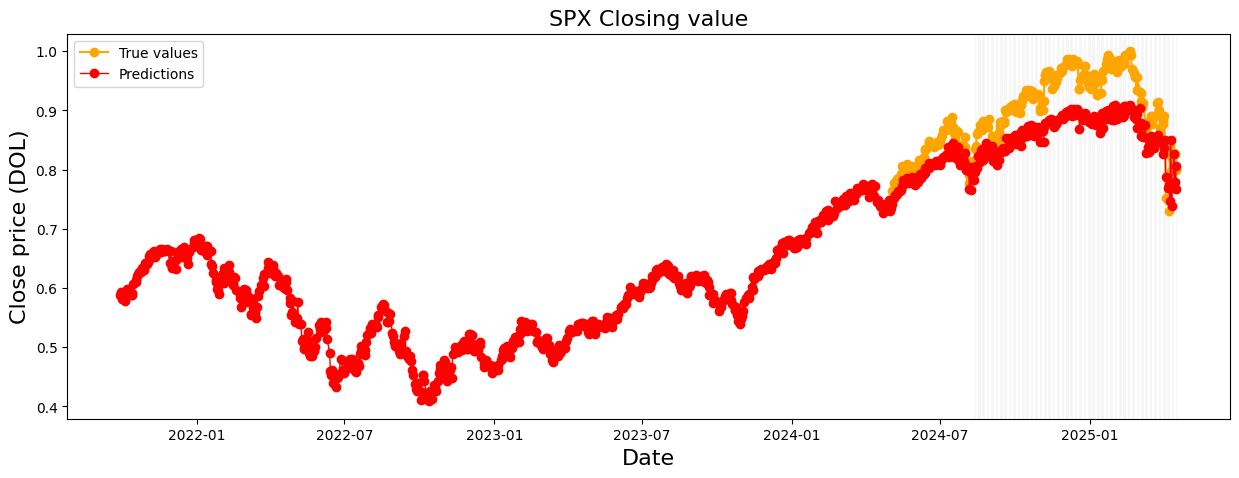

In [ ]:
# Make sure predictions align with the correct test data range
n_days = 240
last_n_days = len(test_data) - n_days

plt.figure(figsize=(15,5))
plt.plot(test_data.Date[last_n_days:], test_data['Close'][last_n_days:], c='orange', marker='o', label='True values')

# Starting from the 15th data point, adjust to fit the shape
plt.plot(test_data.Date[last_n_days-652:], test_predict.flatten(), lw=1, c='r', marker='o', label='Predictions')

plt.legend(loc="upper left")
plt.xlabel("Date", fontsize=16)
plt.ylabel("Close price (DOL)", fontsize=16)
plt.title("SPX Closing value", fontsize=16)

date2 = test_data.Date.tail(1).item()
date1 = date2 - pd.Timedelta(days=n_days+7) 
for i in pd.date_range(date1, date2, periods=n_days+8):
    plt.axvspan(i, i+pd.Timedelta(days=0.6), facecolor='lightgrey', alpha=0.2)

plt.show()


Keep the predicted value and store as part of the input

In [ ]:
# Define look_back and n_features
look_back = 15  # number of past time steps to predict the next value
n_features = 1 

extrapolation = list()
seed_batch = train_predict[:look_back].reshape((1, look_back, n_features))  # Ensure the right shape
current_batch = seed_batch

for i in range(len(test_data)):
    predicted_value = model.predict(current_batch)[0]
    extrapolation.append(predicted_value)
    
    current_batch = np.append(current_batch[:, 1:, :], [[predicted_value]], axis=1)

extrapolation = np.array(extrapolation)

1/1 [==============================] - 0s 22ms/step


In [110]:
extrapolation

array([[0.05295463],
       [0.05050997],
       [0.04831558],
       [0.04706367],
       [0.04607259],
       [0.04496753],
       [0.04373837],
       [0.04258285],
       [0.04162497],
       [0.0408033 ],
       [0.04000197],
       [0.03914213],
       [0.03822552],
       [0.03730976],
       [0.03642715],
       [0.0355888 ],
       [0.03477378],
       [0.03397329],
       [0.03318974],
       [0.0324323 ],
       [0.03170463],
       [0.03100303],
       [0.03032148],
       [0.0296566 ],
       [0.02900894],
       [0.0283802 ],
       [0.02777098],
       [0.02718055],
       [0.02660778],
       [0.02605219],
       [0.02551378],
       [0.02499273],
       [0.02448858],
       [0.02400075],
       [0.02352865],
       [0.02307175],
       [0.02262983],
       [0.02220249],
       [0.02178937],
       [0.02139005],
       [0.0210041 ],
       [0.02063118],
       [0.02027093],
       [0.01992305],
       [0.0195871 ],
       [0.01926282],
       [0.0189497 ],
       [0.018

# Eval LSTM

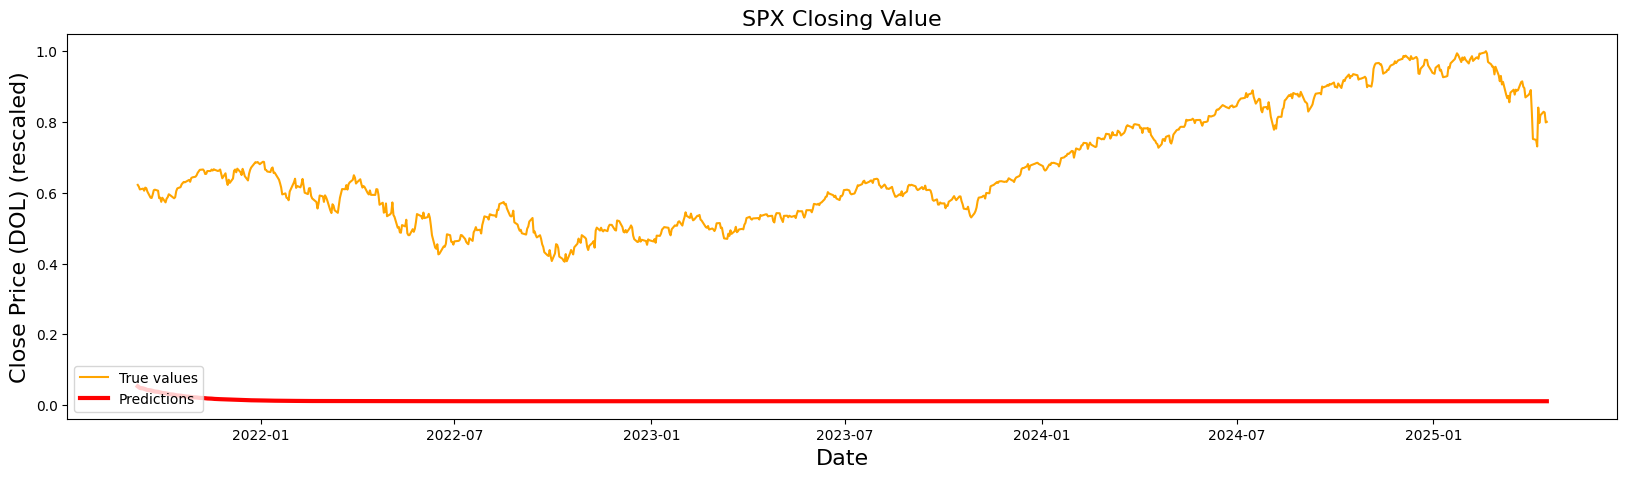

In [111]:
plt.figure(figsize=(20, 5))
plt.plot(test_data.Date, test_data['Close'], c='orange', label='True values')
plt.plot(test_data.Date[look_back-15:], extrapolation, lw=3, c='r', linestyle='-', label='Predictions')
plt.legend(loc="lower left")
plt.xlabel("Date", fontsize=16)
plt.ylabel("Close Price (DOL) (rescaled)", fontsize=16)
plt.title("SPX Closing Value", fontsize=16)
plt.show()


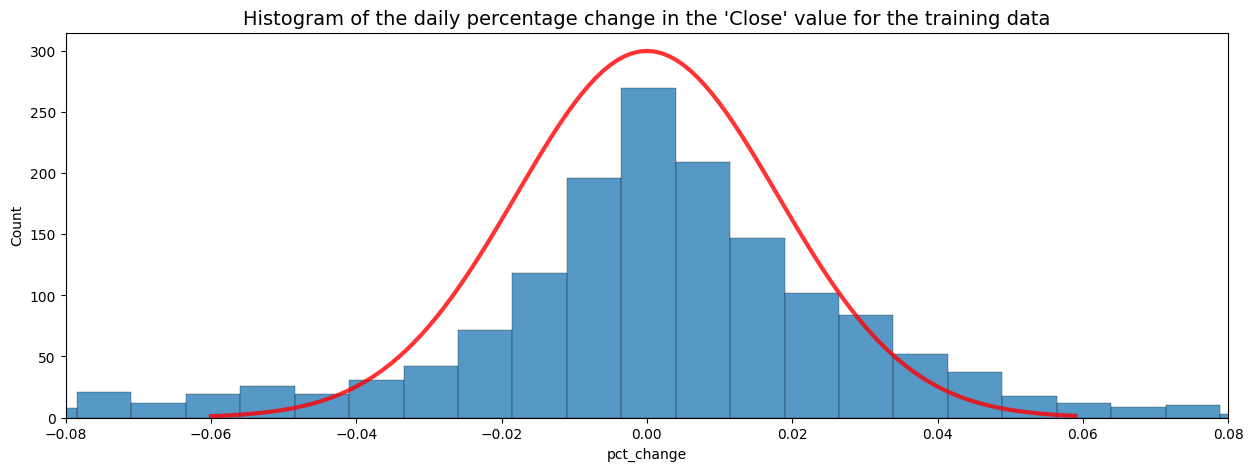

In [112]:
train_data['pct_change'] = train_data.Close.pct_change(periods = 1)

x = np.arange(-0.06, 0.06, 0.001)

# define a Gaussian function
def Gaussian(x,mu,sigma,A):
    return A*np.exp(-0.5 * ((x-mu)/sigma)**2)

plt.figure(figsize = (15,5))
ax = sns.histplot(train_data['pct_change'], binwidth=0.0075)
# overlay a Gaussian distribution, parameters were picked by eye
ax = plt.plot(x,Gaussian(x,0,0.018,300),color='r',lw=3,label='Gaussian #1', alpha=0.8)
plt.title("Histogram of the daily percentage change in the 'Close' value for the training data", size=14)
plt.xlim(-0.08, 0.08);

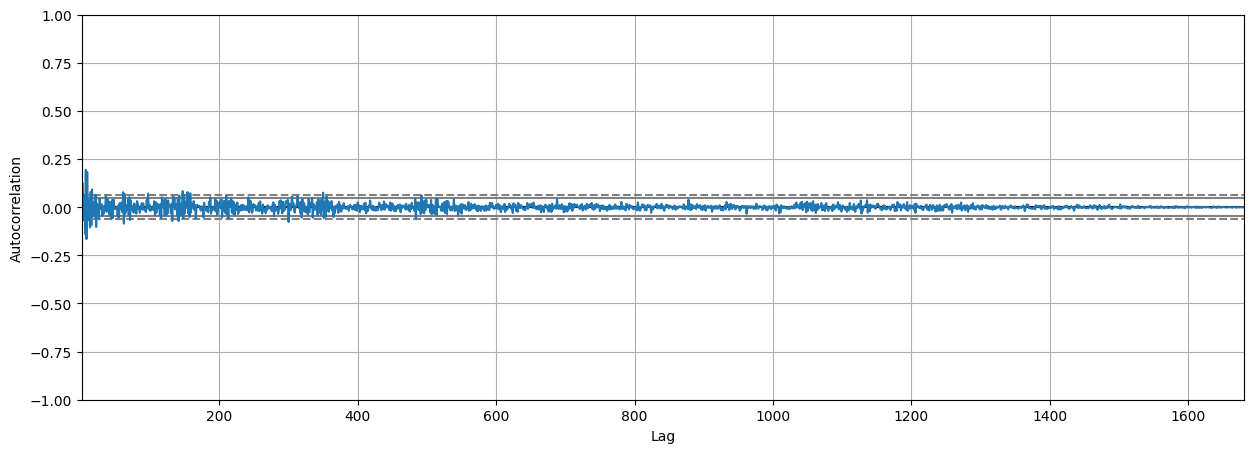

In [113]:
diff_train_data_close = train_data['Close'].diff()
# drop the initial nan
diff_train_data_close = diff_train_data_close.dropna()
# now for the autocorrelation plot
rcParams['figure.figsize'] = 15, 5
pd.plotting.autocorrelation_plot(diff_train_data_close);

In [137]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def evaluate_model(train_data, train_predict, test_data, test_predict):
    train_rmse = np.sqrt(mean_squared_error(train_data, train_predict))
    train_mae = mean_absolute_error(train_data, train_predict)
    train_r2 = r2_score(train_data, train_predict)

    test_rmse = np.sqrt(mean_squared_error(test_data, test_predict))
    test_mae = mean_absolute_error(test_data, test_predict)
    test_r2 = r2_score(test_data, test_predict)

    print(f"{'Metric':<20} {'Train Data':<15} {'Test Data'}")
    print("-" * 50)
    print(f"{'RMSE':<20} {train_rmse:<15.4f} {test_rmse:.4f}")
    print(f"{'MAE':<20} {train_mae:<15.4f} {test_mae:.4f}")
    print(f"{'R²':<20} {train_r2:<15.4f} {test_r2:.4f}")


In [133]:
train_predict_inv = scaler.inverse_transform(train_predict.reshape(-1, 1))
test_predict_inv = scaler.inverse_transform(test_predict.reshape(-1, 1))

y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))


In [136]:
print(f"train_predict_inv shape: {train_predict_inv.shape}")
print(f"y_train_inv shape: {y_train_inv.shape}")
print(f"test_predict_inv shape: {test_predict_inv.shape}")
print(f"y_test_inv shape: {y_test_inv.shape}")

train_predict_inv shape: (1667, 1)
y_train_inv shape: (1667, 1)
test_predict_inv shape: (892, 1)
y_test_inv shape: (892, 1)


In [138]:
evaluate_model(y_train, train_predict_inv.flatten(), y_test, test_predict_inv.flatten())

Metric               Train Data      Test Data
--------------------------------------------------
RMSE                 0.0072          0.0312
MAE                  0.0050          0.0209
R²                   0.9976          0.9625


# Prediction

In [176]:
time_prev = 28
x_input=y_test[len(y_test)-time_prev:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_prev
i=0
pred_days = 7
while(i<pred_days):
    
    if(len(temp_input)>time_prev):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  7


In [177]:
last_days=np.arange(1,time_prev+1)
day_pred=np.arange(time_prev+1,time_prev+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28]
[29 30 31 32 33 34 35]


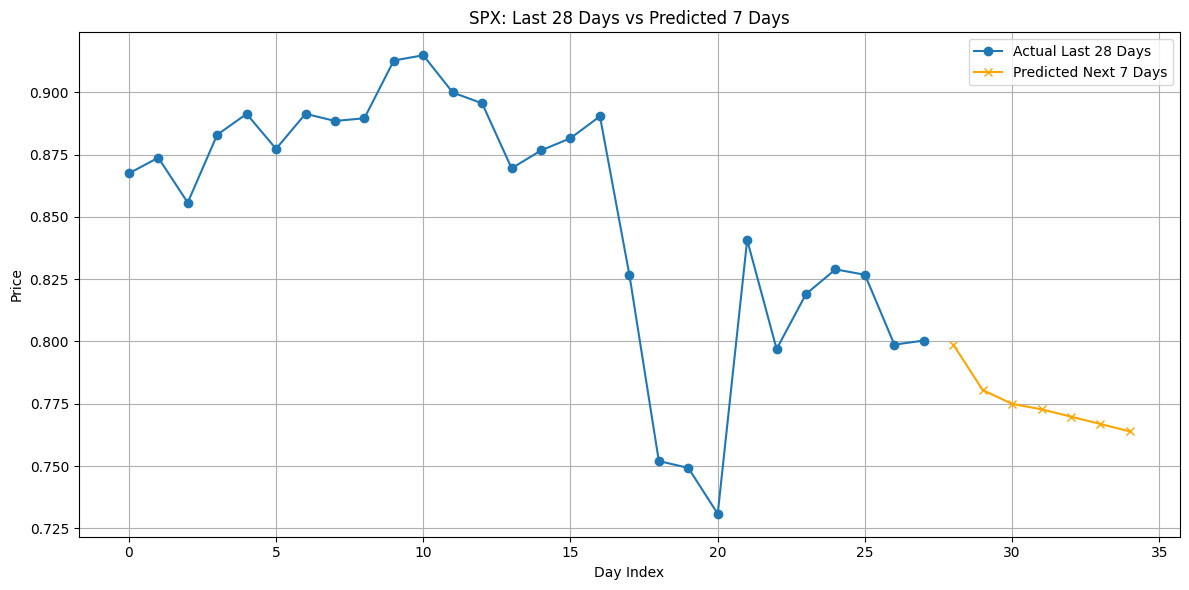

In [190]:
total_len = time_prev + pred_days
last_actual_values = [np.nan] * time_prev
predicted_values = [np.nan] * pred_days 

last_actual_scaled = closedf['Close'][-time_prev:].values.reshape(-1, 1)
#last_actual = scaler.inverse_transform(last_actual_scaled).flatten().tolist()
last_actual_values[0:time_prev] = last_actual

future_preds = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1)).flatten().tolist()
predicted_values[time_prev:] = future_preds

actual_x = list(range(time_prev))                      # 0 to 27
predicted_x = list(range(time_prev, total_len))        # 28 to 34

last_actual_scaled = closedf['Close'][-time_prev:].values.reshape(-1, 1)
last_actual = scaler.inverse_transform(last_actual_scaled).flatten().tolist()

future_preds = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1)).flatten().tolist()

plt.figure(figsize=(12, 6))
plt.plot(actual_x, last_actual, label='Actual Last 28 Days', marker='o')
plt.plot(predicted_x, future_preds, label='Predicted Next 7 Days', marker='x', color='orange')
plt.title('SPX: Last 28 Days vs Predicted 7 Days')
plt.xlabel('Day Index')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# LSTM + GRU

In [78]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (1667, 15, 1)
X_test:  (892, 15, 1)


In [114]:
tf.keras.backend.clear_session()
model1=Sequential()
model1.add(LSTM(32,return_sequences=True,input_shape=(time_step,1)))
model1.add(LSTM(32,return_sequences=True))
model1.add(GRU(32,return_sequences=True))
model1.add(GRU(32))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error',optimizer='adam')
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 15, 32)            8320      
                                                                 
 gru (GRU)                   (None, 15, 32)            6336      
                                                                 
 gru_1 (GRU)                 (None, 32)                6336      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 25377 (99.13 KB)
Trainable params: 25377 (99.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [115]:
model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=5,verbose=1)

Epoch 1/200
334/334 [==============================] - 27s 45ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 2/200
334/334 [==============================] - 11s 34ms/step - loss: 4.1110e-04 - val_loss: 0.0018
Epoch 3/200
334/334 [==============================] - 11s 32ms/step - loss: 3.9421e-04 - val_loss: 0.0052
Epoch 4/200
334/334 [==============================] - 15s 44ms/step - loss: 3.4063e-04 - val_loss: 7.3182e-04
Epoch 5/200
334/334 [==============================] - 16s 49ms/step - loss: 3.0319e-04 - val_loss: 6.4442e-04
Epoch 6/200
334/334 [==============================] - 11s 33ms/step - loss: 2.3446e-04 - val_loss: 6.2155e-04
Epoch 7/200
334/334 [==============================] - 14s 42ms/step - loss: 2.4948e-04 - val_loss: 8.5748e-04
Epoch 8/200
334/334 [==============================] - 15s 45ms/step - loss: 2.1887e-04 - val_loss: 5.4047e-04
Epoch 9/200
334/334 [==============================] - 12s 35ms/step - loss: 2.0501e-04 - val_loss: 4.2177e-04
Epoch 10/200
334/

In [131]:
train_predict1=model1.predict(X_train)
test_predict1=model1.predict(X_test)
train_predict1.shape, test_predict1.shape

28/28 [==============================] - 0s 11ms/step


((1667, 1), (892, 1))

# Evaluation

In [139]:
evaluate_model(y_train, train_predict1.flatten(), y_test, test_predict1.flatten())

Metric               Train Data      Test Data
--------------------------------------------------
RMSE                 0.0092          0.0597
MAE                  0.0072          0.0386
R²                   0.9961          0.8629


# Naive forecast

In [29]:
test_data['naive'] = test_data['Close'].shift(1)

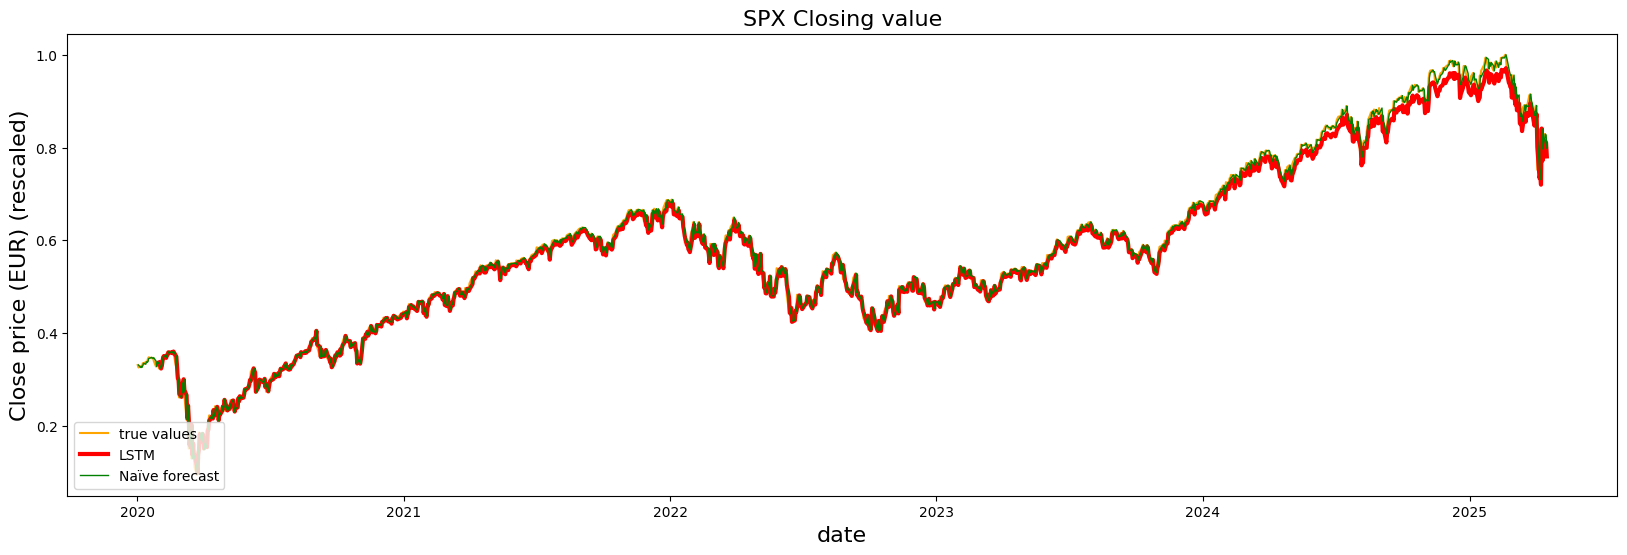

In [30]:
plt.figure(figsize=(20,6))
plt.plot(test_data.Date, test_data['Close'], c='orange',label='true values')
plt.plot(X_test[20:],test_predictions, lw=3, c='r',linestyle = '-', label='LSTM')
plt.plot(test_data.Date,test_data['naive'], lw=1, c='green',linestyle = '-', label='Naïve forecast')
plt.legend(loc="lower left")
plt.xlabel("date", fontsize=16)
plt.ylabel("Close price (EUR) (rescaled)", fontsize=16)
plt.title("SPX Closing value", fontsize=16);

# Performance

In [31]:
# MSE and MAE
# first create a pad of length "look_back"
twenty_zeros = np.zeros((look_back,1))
# now insert the LSTM predictions into the dataframe
test_data["LSTM"] = np.concatenate([twenty_zeros,test_predictions])

from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

print("Naïve model MSE: %.4f" % mean_squared_error(test_data[20:]["Close"], test_data[20:]["naive"]))
print("LSTM model  MSE: %.4f" % mean_squared_error(test_data[20:]["Close"], test_data[20:]["LSTM"]))
print("Naïve model MAE: %.4f" % median_absolute_error(test_data[20:]["Close"], test_data[20:]["naive"]))
print("LSTM model  MAE: %.4f" % median_absolute_error(test_data[20:]["Close"], test_data[20:]["LSTM"]))

Naïve model MSE: 0.0002
LSTM model  MSE: 0.0002
Naïve model MAE: 0.0063
LSTM model  MAE: 0.0091
